In [ ]:
# import basic python packages
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

from typing import Tuple
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Add repo root to path so we can import the shared kmorfs package
sys.path.insert(0, '..')
# Import only the numpy-based batch function directly to avoid loading torch
from kmorfs.stress_equation_notorch import stress_equation_batch

In [ ]:
# this one loads SSSF example stress data
Data = pd.read_csv('Ti-Zr-N.csv')

# it is a previous trained parameter set from Ti-Zr-N system
parameter = {'sigma0':[1.068,0.445,2.606],
            'betaD':[0.076,0.0001,0.231],
            'diffusivity':[5.400,4.771,0.8],
            'p0':[0.301,0.391,0.376],
            'aprime':[-71.553,-60.955,-66.254],
            'bprime':[-0.952,-76.157,-38.555],
            'lprime':[0.28,0.40,0.34],
            'grainSize':[14,11,14],
            'composition':[0,1,0.5],      
        }

# convert betaD at room temperature (becuase our SSSF example data do not have temperature dependence)
parameter['betaD'] = (np.array(parameter['betaD']) * (8.6173324e-5 * 300)).tolist()

In [ ]:
# Preprocess input features

# raw measured stress data 
y = Data['stress (Gpa)'].to_numpy()

# Set composition
Data['composition'] = Data['material'].map({'TiN':0,'TiZrN2':0.5,'ZrN':1})

# Process conditions, set into X
if 'thickness (nm)' in Data.columns:
        Process_para = Data[['R','P','T','thickness (nm)','composition']].to_numpy()
else:
        Data['thickness (nm)'] = np.zeros(len(Data))
        Process_para = Data[['R','P','T','thickness (nm)','composition']].to_numpy()

# Loop over each composition to set parameters
# parameter should be lists of same length as number of unique compositions
parameter_keys = ['sigmaC','a1','L0','grainSize','Mfda','lprime',\
                'sigma0','betaD','Ea','aprime','bprime','diffusivity','p0']
param_to_model = np.zeros((len(Data['material']), len(parameter_keys)))

# Build lookup from composition value to parameter list index
comp_to_idx = {c: i for i, c in enumerate(parameter['composition'])}

for idx in Data['composition'].index:
    comp = Data['composition'][idx]
    for key in parameter_keys:
        if key in parameter:
            param_to_model[idx, parameter_keys.index(key)] = parameter[key][comp_to_idx[comp]]
        else:
            # for SSSF-specific parameters not used in this model
            param_to_model[idx, parameter_keys.index(key)] = 0.0

# Combine input features and parameters for a single input X
X = np.hstack((Process_para, param_to_model))

print('Parameter matrix shape:', param_to_model.shape)
print('Input feature matrix shape:', X.shape)
print('Output stress vector shape:', y.shape)


In [ ]:
# this part is for plotting each composition's data and model
# the samples are grouped by 'material' column in the Data dataframe
# Note that we use a very very optimized initial parameter set here for demonstration
# so the model prediction should be close to the experimental data

mater_sequence = Data['material'].unique()
print(mater_sequence)
stack_pred_stress = []

for idx,mater in enumerate(mater_sequence):

    test_data = Data.groupby('material').get_group(mater)
    X_test = X[Data['material'] == mater]
    R, P, T = test_data['R'], test_data['P'], test_data['T']
    
    stress_exp = y[Data['material'] == mater]
    stress_model = np.zeros_like(stress_exp)
    out = stress_equation_batch(
        X_test,
        mode = "steady state")

    stress_model = np.array(out[0])  
    stack_pred_stress.append(stress_model)
    plt.figure()
    plt.plot(R,stress_exp,'o',label='exp')
    plt.plot(R,stress_model,'o',label='model')
    plt.xlabel('growth rate (nm/s)')
    plt.ylabel('stress (GPa)')
    plt.title(mater)
    plt.ylim([-2.5,2])
    plt.legend()
    plt.show()
    #plt.close()

['TiN' 'ZrN' 'TiZrN2']


: 

In [ ]:
# Now we begin the real fitting routine

# find trained parameter indices that is in parameter but not in parameter_keys
parameter_keys_idx = []
for key in parameter.keys():
    if key in parameter_keys:
        parameter_keys_idx.append(parameter_keys.index(key))



#        parameter['grainSize'][idx],
#        parameter['lprime'][idx],
#        parameter['sigma0'][idx],
#        parameter['betaD'][idx],
#        parameter['aprime'][idx],
#        parameter['bprime'][idx],
#        parameter['diffusivity'][idx],
#        parameter['p0'][idx],

# this one define the bound for each parameter to be optimized
Bound ={
    'parameter_keys':sorted(parameter_keys_idx),
    'lower':[0.1, 0.1, 1e-6, 1e-16, -500, -500   , 0.01, 0.1],
    'upper':[20,  2,   20  , 2    , -1e-6,   -1e-6   , 1,   2],
    'alloy_dependent_keys':[5,9,10]
}
print(sorted(parameter_keys_idx))
print(Bound['alloy_dependent_keys'])

[3, 5, 6, 7, 9, 10, 11, 12]
[5, 9, 10]


In [ ]:
# Define the steady_state_model class

from typing import Callable

class steady_state_model:
    # Initialize with input features X and bounds
    # X shape: first 5 columns are process parameters, rest are material parameters
    def __init__(self, 
        X:          np.ndarray, 
        Bound:      dict, 
        stress_fn:  callable=stress_equation_batch,
        mode:       str='steady state'):

        self.process_condition = X[:,:4]
        self.composition = X[:,4]
        self.parameter_keys = Bound['parameter_keys']
        self.lower = np.array(Bound['lower'])
        self.upper = np.array(Bound['upper'])
        self.alloy_dependent_keys = Bound['alloy_dependent_keys']

        self.stress_fn = stress_fn
        self.mode = mode

        assert len(self.lower) == len(self.parameter_keys), "Lower bounds length must match number of parameters to optimize."
        assert len(self.upper) == len(self.parameter_keys), "Upper bounds length must match number of parameters to optimize."

        # create initial parameter matrix
        X_init = np.zeros((X.shape[0], len(self.parameter_keys)))
        for i, key_idx in enumerate(self.parameter_keys):
            X_init[:,i] = X[:,key_idx+5]

        # for this set, parameters are same for the same composition
        # so we need to only keep unique rows
        unique_compositions, unique_indices = np.unique(self.composition, return_index=True)
        unique_X_init = X_init[unique_indices]

        # Normalize initial parameters to 0-1 with min-max scaling        
        self.parameter = (unique_X_init - self.lower) / (self.upper - self.lower + 1e-8)
        self.Z = self.parameter.flatten()

    def forward(self, curr_Z:np.ndarray) -> np.ndarray:

        # Update the parameter matrix with current parameters
        # first denormalize with logistic to map to bounds
        
        X = self._assemble_input(curr_Z)
        y_pred = stress_equation_batch(X, mode='steady state')[0]

        return y_pred

    def predict(self) -> np.ndarray:
        # Predict stress using current parameter
        return self.forward(self.Z)
    
    def fit(self, y_true:np.ndarray, 
            optimizer:str='L-BFGS-B', 
            maxiter:int=300,
            tol:float=1e-6,
            options:dict=None):
        
        # for now we use a very simple optimizer from scipy
        from scipy.optimize import minimize

        def objective_function(curr_Z_flat:np.ndarray):

            # First apply alloy parameter assembly if needed
            if self.alloy_dependent_keys:
                curr_Z_flat = self._alloy_parameter_assembly(curr_Z_flat)
            # Reshape curr_Z_flat to curr_Z matrix
            curr_Z = curr_Z_flat.reshape(self.Z.shape)
            y_pred = self.forward(curr_Z)
            loss = np.mean((y_true - y_pred)**2)
            return loss

        # Initial guess flattened
        Z0_flat = self.Z.flatten()

        # Optimize using scipy's minimize
        result = minimize(
            objective_function, 
            Z0_flat, 
            method=optimizer, 
            bounds=[(0,1) for _ in range(len(Z0_flat))],
            options=options
            )

        # Update self.Z with optimized parameters
        self.Z = result.x.reshape(self.Z.shape)
        # apply alloy parameter assembly if needed
        if self.alloy_dependent_keys:
            self.Z = self._alloy_parameter_assembly(self.Z).reshape(self.Z.shape)

        return self.Z, result.fun


    def _assemble_input(self, curr_Z:np.ndarray) -> np.ndarray:
        # Assemble the full input feature matrix X with updated parameters
        if curr_Z is None:
            curr_Z = self.Z.flatten()

        if self.mode == 'steady state':

            X_updated = np.zeros((self.process_condition.shape[0], len(self.parameter_keys) + 5 + 5))
            X_updated[:,:4] = self.process_condition
            X_updated[:,4] = self.composition

            # Reconstruct into groups and Denormalize parameters
            curr_Z = curr_Z.reshape(len(np.unique(self.composition)), len(self.parameter_keys))
            X_params = self.lower + (self.upper - self.lower + 1e-8) * curr_Z

            # Map parameters back to full X matrix
            for i, key_idx in enumerate(self.parameter_keys):
                for comp_idx, comp in enumerate(np.unique(self.composition)):
                    indices = np.where(self.composition == comp)[0]
                    X_updated[indices, key_idx+5] = X_params[comp_idx, i]

        return X_updated
    
    def _alloy_parameter_assembly(self, curr_Z:np.ndarray) -> np.ndarray:
        # Assemble alloy parameters from curr_Z
        if self.mode == 'steady state':
            curr_Z_updated = curr_Z.copy().reshape(len(np.unique(self.composition)), len(self.parameter_keys))

            ele0_indices = np.where(np.unique(self.composition) == 0)[0]
            ele1_indices = np.where(np.unique(self.composition) == 1)[0]
            
            for i, key_idx in enumerate(self.parameter_keys):
                if key_idx in self.alloy_dependent_keys:
                    for comp_idx, comp in enumerate(np.unique(self.composition)):
                        if comp not in [0,1]:
                            frac = comp
                            curr_Z_updated[comp_idx, i] = (1 - frac) * curr_Z_updated[ele0_indices[0], i] \
                                + frac * curr_Z_updated[ele1_indices[0], i]

        return curr_Z_updated.flatten()


In [ ]:
# This cell tests the steady_state_model class

# call the model class to transfer X and Bound into the model
model = steady_state_model(
    X = X,
    Bound = Bound
)

# use numpy comparisons for arrays to avoid ambiguous truth value
assert np.allclose(model.process_condition, Process_para[:,:4])
assert np.allclose(model.composition, Process_para[:,4])

# parameter_keys should match the Bound entry used to construct the model
assert model.parameter_keys == Bound['parameter_keys']

# check bounds
assert np.allclose(model.lower, np.array(Bound['lower']))
assert np.allclose(model.upper, np.array(Bound['upper']))

# check initial parameter normalization
X_init_test = np.zeros((X.shape[0],len(model.parameter_keys)))
for i, key_idx in enumerate(model.parameter_keys):
    X_init_test[:,i] = X[:,key_idx+5]
X_init_test_normalized = (X_init_test - model.lower) / (model.upper - model.lower + 1e-8)
X_init_test_normalized = X_init_test_normalized[np.unique(model.composition, return_index=True)[1]]
assert np.allclose(model.parameter, X_init_test_normalized)

# check _assemble_input method
X_assembled = model._assemble_input(model.Z)
assert X_assembled.shape == (X.shape[0], X.shape[1])
assert np.allclose(X_assembled, X)

# test forward method
y_pred = model.forward(model.Z)
assert y_pred.shape == y.shape
# scale stack_pred_stress to a single array for comparison
assert np.allclose(y_pred, np.hstack(stack_pred_stress))

print("All tests passed!")

All tests passed!


In [ ]:
# now test fitting routine with a random initial guess
parameter = {'sigma0':[1,1,1],
            'betaD':[0.1,0.1,0.1],
            'diffusivity':[2,2,2],
            'p0':[0.5,0.5,0.5],
            'aprime':[-50,-50,-50],
            'bprime':[-50,-50,-50],
            'lprime':[0.4,0.4,0.4],
            'grainSize':[14,11,14],
            'composition':[0,1,0.5],      
        }
parameter['betaD'] = (np.array(parameter['betaD']) * (8.6173324e-5 * 300)).tolist()
# raw measured stress data 
y = Data['stress (Gpa)'].to_numpy()
# Set composition
Data['composition'] = Data['material'].map({'TiN':0,'ZrN':1,'TiZrN2':0.5})
# Process conditions, set into X
if 'thickness (nm)' in Data.columns:
        Process_para = Data[['R','P','T','thickness (nm)','composition']].to_numpy()
else:
        Data['thickness (nm)'] = np.zeros(len(Data))
        Process_para = Data[['R','P','T','thickness (nm)','composition']].to_numpy()
# Loop over each composition to set parameters
# parameter should be lists of same length as number of unique compositions
parameter_keys = ['sigmaC','a1','L0','grainSize','Mfda','lprime',\
                'sigma0','betaD','Ea','aprime','bprime','diffusivity','p0']
param_to_model = np.zeros((len(Data['material']), len(parameter_keys)))

# Build lookup from composition value to parameter list index
comp_to_idx = {c: i for i, c in enumerate(parameter['composition'])}

for idx in Data['composition'].index:
    comp = Data['composition'][idx]
    for key in parameter_keys:
        if key in parameter:
            param_to_model[idx, parameter_keys.index(key)] = parameter[key][comp_to_idx[comp]]
        else:
            # for SSSF-specific parameters not used in this model
            param_to_model[idx, parameter_keys.index(key)] = 0.0

# Combine input features and parameters for a single input X
X = np.hstack((Process_para, param_to_model))

In [ ]:
# set random seed for reproducibility
import random
random.seed(2025)

# import the steady_state_model class defined above
model = steady_state_model(X, Bound)

optimizer = 'L-BFGS-B'  
y0 = model.predict()
final_Z, final_loss = model.fit(y, optimizer=optimizer, maxiter=500, tol=1e-6)


In [ ]:
# print final results
print("Final loss:", final_loss)
print("Optimized parameters (denormalized):")
p_opt = model.lower + (model.upper - model.lower + 1e-8) * final_Z.reshape(len(np.unique(model.composition)), len(model.parameter_keys))
for i, key_idx in enumerate(model.parameter_keys):      
    print(f"{key_idx}: {p_opt[:,i]}")

Final loss: 0.05360283301799324
Optimized parameters (denormalized):
3: [19.91523572 12.67827405 11.62833159]
5: [0.1        1.04895544 1.99791088]
6: [ 1.93367537  5.66049154 19.9832085 ]
7: [2.00000001 0.01332362 0.28533668]
9: [-6.20114500e+01 -3.10057255e+01 -9.89999990e-07]
10: [-33.76579822 -18.66525454  -3.56471086]
11: [0.89458794 0.89325656 0.12884166]
12: [0.21064242 0.34169998 0.34438724]


In [ ]:
# This our color scheme for plotting
plot_color = np.array(["#5B9BD5",  # Soft Blue
    "#A5D6A7",  # Soft Green
    "#F1C40F",  # Warm Yellow
    "#E74C3C",  # Muted Red
    "#9B59B6",  # Soft Purple
    "#F39C12",  # Orange
    "#1F77B4",  # Cool Blue
    "#BDC3C7"   # Light Gray
    ])
    

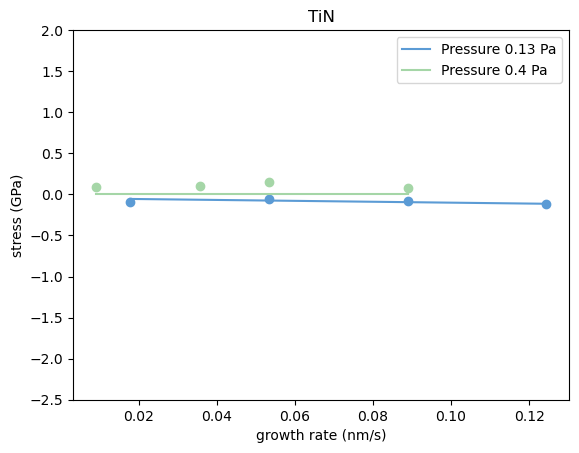

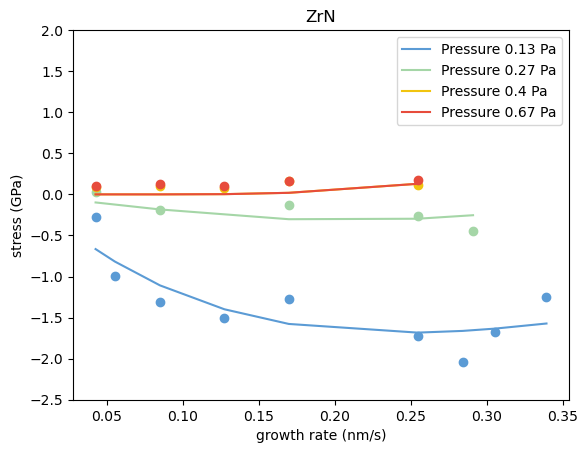

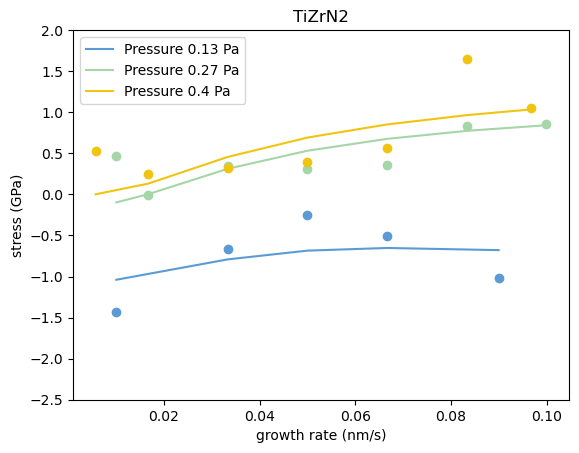

In [ ]:
# plot the final prediction after fitting
y_final_pred = model.predict()

for idx,mater in enumerate(mater_sequence):

    test_data = Data.groupby('material').get_group(mater)
    mater_indices = Data['material'] == mater
    X_test = X[mater_indices]
    R, P, T = test_data['R'], test_data['P'], test_data['T']
    plt.figure()
    # seperate it by the Pressure
    color_idx = 0
    for pressure in np.unique(P):
        pressure_indices = mater_indices & (Data['P'] == pressure)
        stress_exp = y[pressure_indices]
        stress_model = y_final_pred[pressure_indices]
        plt.plot(R[pressure_indices[mater_indices]],stress_exp,'o',color = plot_color[color_idx])
        plt.plot(R[pressure_indices[mater_indices]],stress_model, color = plot_color[color_idx],label='Pressure '+str(pressure)+' Pa')
        color_idx += 1
    plt.xlabel('growth rate (nm/s)')
    plt.ylabel('stress (GPa)')
    plt.title(f"{mater}")
    plt.ylim([-2.5,2])
    plt.legend()
        
plt.show()
#plt.close()